# 作业三：实战CNN —— CIFAR-10图像分类


| 姓名 | 学号 |
| :--: | :--: |
| xxx | xxx |


### 要求：

<font color=Red>完成以下notebook，CIFAR数据集的下载和处理代码已经给出，请同学们自行完成训练过程。作业提交 jupyter notebook 文件。</font>

CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。

一共包含 10 个类别的 RGB 彩色图 片：飞机（ airlane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练图片和 10000 张测试图片。

## 下载和缓存数据集

这里实现了几个函数来下载 CIFAR-10 数据集， CIFAR_URL是下载数据集的网址。

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
from torch.utils import data
from d2l import torch as d2l

CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

下面的`download`函数用来下载并解压缩数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中。
如果缓存目录中已经存在此数据集文件，并且其名称与下载文件名匹配，
我们将使用缓存的文件，以避免重复的下载。

下载完成后函数执行解压缩，为避免重复解压缩，同样检查是否有文件名相匹配。

In [2]:
def downloadCIFAR():
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dic')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')
        
downloadCIFAR()

CIFAR exist
CIFAR unpacked


## 数据处理

下面的代码用作处理数据。
 
CIFAR数据保存为 `pkl` 格式，需要加载 `pickle` 来读取文件，下面的 `unpickle` 函数实现了读取 `pkl` 文件并返回 `List` 的功能。

可以尝试展示一下读取的数据，下面的 `show_img` 函数实现了读取数据并展示图片和label的功能

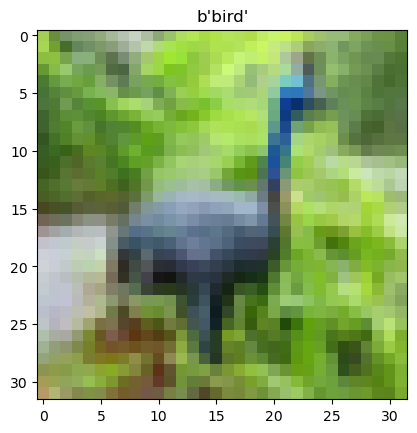

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()

    
show_img(6)

下面的代码实现了将读取到的数据转为torch.tensor以及一系列形状操作。

<font color=Red>完成作业时可以参考下面的代码，也可以自己实现相关功能。<font>

In [4]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)
print(train_data.mean())
print(test_data.mean())

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])
tensor(120.7076)
tensor(121.5292)


# <font color=Red>训练（自行完成）<font>

看到这里，请同学自己完成从**定义data loader、定义网络、定义损失函数、定义优化器到进行训练等一系列深度学习流水线**。
    
神经网络请使用 ***卷积神经网络*** ，可以使用现有论文模型，也可以自己提出改进或提出新模型。

不限制手写或使用 `torch.nn`等高级API，视手写代码占比有一定程度加分（最多加1分）。

## 定义网络
使用ResNet残差神经网络来进行图像分类。这里使用改编的ResNet来实现网络。

### 定义普通残差模块

In [5]:
class BasicBlock(nn.Module):
    # 输出通道数比输入通道数的倍数
    expansion: int = 1

    def __init__(self, in_channels: int, first_out_channels: int, stride: int=1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, first_out_channels, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(first_out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(first_out_channels, first_out_channels, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(first_out_channels)
        # 若输入通道不等于输出通道，则需要对恒等映射进行下采样
        if in_channels != first_out_channels*self.expansion:
            self.downsample = nn.Sequential(
                    nn.Conv2d(in_channels, first_out_channels * BasicBlock.expansion, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(first_out_channels * BasicBlock.expansion),
                )
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 恒等映射
        identity = x
        # print(x.shape)
        # print(out.shape)
        # print(identity.shape)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        # 输出再次经过relu激活函数
        output = self.relu(out)

        return output

### 定义bottleneck残差模块
当ResNet的层数大于等于50时，为了减少计算量，提高计算效率，将使用bottleneck残差结构来进行shortcut。

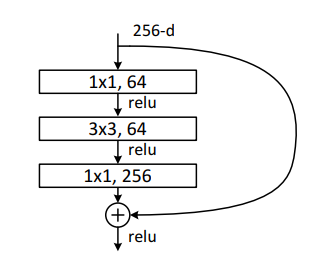

In [6]:
class Bottlenect(nn.Module):
    # 输出通道是输入通道数的expansion倍
    expansion: int = 4
    # first_out_channels指的是第一层输出通道数
    def __init__(self, in_channels: int, first_out_channels: int, stride: int=1) -> None:
        super().__init__()
        # bias指的是添加偏置项，即b
        self.conv1 = nn.Conv2d(in_channels, first_out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(first_out_channels)
        self.conv2 = nn.Conv2d(first_out_channels, first_out_channels, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(first_out_channels)
        self.conv3 = nn.Conv2d(first_out_channels, first_out_channels*self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(first_out_channels*self.expansion)
        # inplace为True，将会改变输入的数据
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        # 若输入通道不等于输出通道，则需要对恒等映射进行下采样
        if in_channels != first_out_channels*self.expansion:
            self.downsample = nn.Sequential(
                    nn.Conv2d(in_channels, first_out_channels * Bottlenect.expansion, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(first_out_channels * Bottlenect.expansion),
                )
        else:
            self.downsample = None


    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # 恒等映射
        identity = input

        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample != None:
            identity = self.downsample(input)
        # print(input.shape)
        # print(out.shape)
        # print(identity.shape)
        out += identity
        output = self.relu(out)

        return output
    

### ResNet网络定义

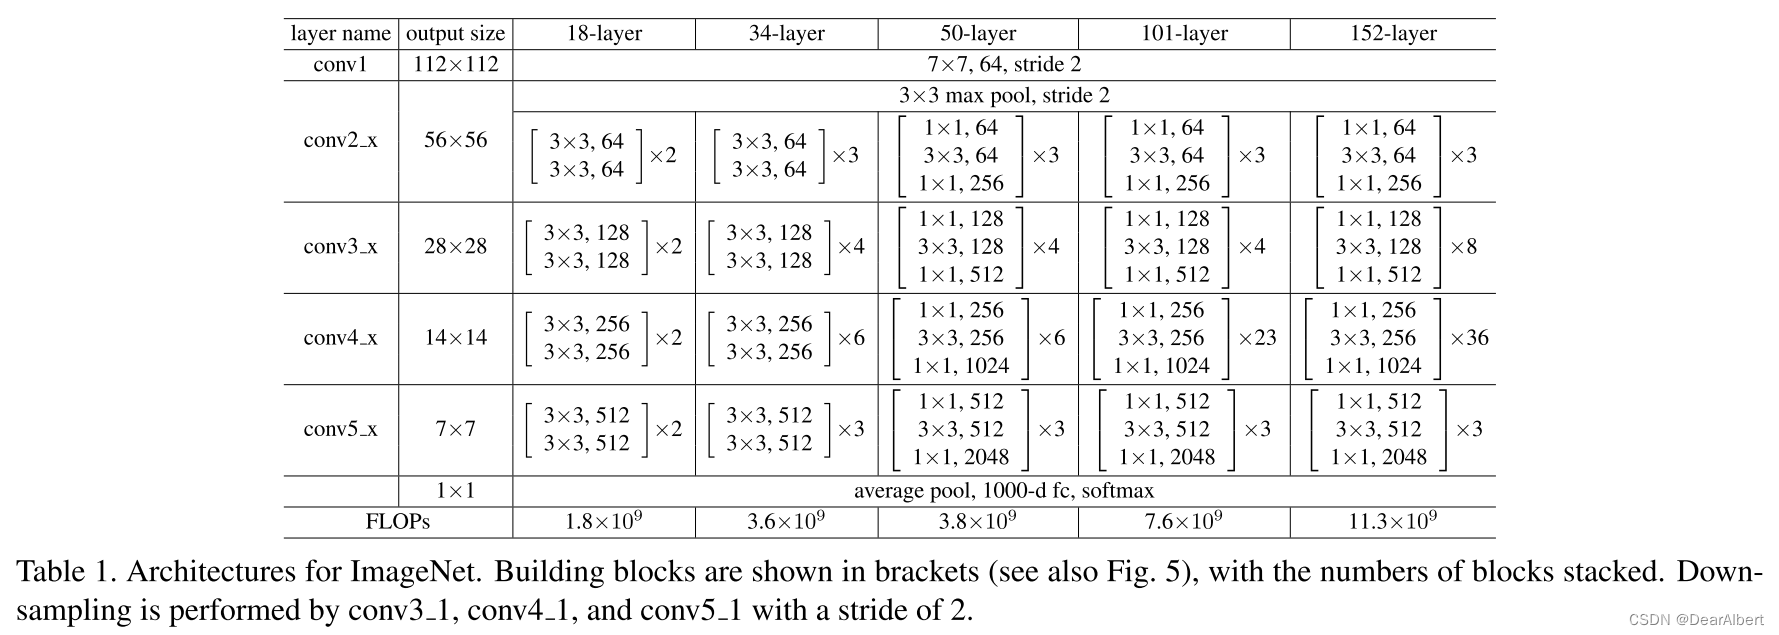

ResNet的前两层为输出通道数为64、步幅为2的7×7卷积层，后接步幅为2的3×3的最大池化层。

ResNet使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [7]:
class ResNet(nn.Module):
    def __init__(self, layers: list, num_classes: int = 10):
        super().__init__()
        # 输入3*32*32
        # 对应图中的layer_name为conv1的层
        # 输出64*16*16
        self.conv1 = nn.Conv2d(3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # # 输出64*8*8
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4个残差块
        self.layer1 = self.make_residual_block(64, layers[0], stride=1)
        self.layer2 = self.make_residual_block(128, layers[1], stride=2)
        self.layer3 = self.make_residual_block(256, layers[2], stride=2)
        # self.layer4 = self.make_residual_block(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * BasicBlock.expansion, num_classes)

        # 初始化不同网络层的权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_residual_block(self, first_out_channels, num_residual, stride=1):
        # 包含所有卷积块
        layers = []
        # 残差结构中的第一个残差模块可能改变图像大小，单独列出
        if stride == 1:
            # 第一个残差结构输入是first_out_channels，即64
            layers.append(BasicBlock(first_out_channels, first_out_channels, stride))
        else:
            # 其他残差结构输入通道数
            layers.append(BasicBlock(first_out_channels//2, first_out_channels, stride))
        

        for _ in range(1, num_residual):
            layers.append(BasicBlock(first_out_channels*BasicBlock.expansion, first_out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, input: torch.tensor) -> torch.tensor:
        # print(input.shape)
        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu(out)
        # out = self.maxpool(out)
        # print(out.shape)
        out = self.layer1(out)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        out = self.layer3(out)
        # out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        output = self.fc(out)

        return output


## 数据迭代器

In [8]:
def data_iter(data_arrays, batch_size, is_train=True):
    """ 构造一个数据迭代器 """
    
        # data_arrays[0] = test_transforms(data_arrays[0])
    dataset = data.TensorDataset(*data_arrays)
    # train_transforms(dataset)
    return enumerate(data.DataLoader(dataset, batch_size, shuffle=True))

## 计算准确率

In [9]:
def accuracy(y_hat, y):
    """计算预测正确的数量""" 
    # y_hat的shape为(num_examples, 分类的类别数), y的shape为每个example的正确分类 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: 
        y_hat = y_hat.argmax(axis=1) 
    cmp = y_hat.type(y.dtype) == y 
    return float(cmp.type(y.dtype).sum())

## 超参数、优化器和损失函数的定义；数据预处理

In [10]:
import torchvision
epochs = 100
device = 'gpu'
lr = 0.1
batch_size = 128
# net = torchvision.models.resnet50(pretrained=False)
net = ResNet([1, 1, 1], num_classes=10)

# 交叉熵损失函数，不用进行独热编码和softmax
loss = nn.CrossEntropyLoss(reduction='none')
# sgd优化器
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.0001,momentum=0.9)
torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5, last_epoch=-1)

print(train_data[0])
print(test_data[-1])
train_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转 选择一个概率概率
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 均值，标准差
        ])
test_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for _ in range(len(test_data)):
    test_data[_] = test_transforms(test_data[_])

print('数据预处理完毕！')
print(train_data[0])
print(test_data[-1])
train_ds = (train_data, train_labels)
test_ds = (test_data, test_labels)

tensor([[[ 59.,  43.,  50.,  ..., 158., 152., 148.],
         [ 16.,   0.,  18.,  ..., 123., 119., 122.],
         [ 25.,  16.,  49.,  ..., 118., 120., 109.],
         ...,
         [208., 201., 198.,  ..., 160.,  56.,  53.],
         [180., 173., 186.,  ..., 184.,  97.,  83.],
         [177., 168., 179.,  ..., 216., 151., 123.]],

        [[ 62.,  46.,  48.,  ..., 132., 125., 124.],
         [ 20.,   0.,   8.,  ...,  88.,  83.,  87.],
         [ 24.,   7.,  27.,  ...,  84.,  84.,  73.],
         ...,
         [170., 153., 161.,  ..., 133.,  31.,  34.],
         [139., 123., 144.,  ..., 148.,  62.,  53.],
         [144., 129., 142.,  ..., 184., 118.,  92.]],

        [[ 63.,  45.,  43.,  ..., 108., 102., 103.],
         [ 20.,   0.,   0.,  ...,  55.,  50.,  57.],
         [ 21.,   0.,   8.,  ...,  50.,  50.,  42.],
         ...,
         [ 96.,  34.,  26.,  ...,  70.,   7.,  20.],
         [ 96.,  42.,  30.,  ...,  94.,  34.,  34.],
         [116.,  94.,  87.,  ..., 140.,  84.,  72.]]]

## 训练函数的定义

In [11]:
def train(net, optimizer, loss, train_ds, test_ds, epochs=40, device='gpu', batch_size=64):
    # 在gpu上进行训练
    if device == 'gpu' and torch.cuda.is_available():
        net = net.to('cuda:0')
        print('在GPU上进行训练和测试')

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    # animator_acc = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.3, 1],
    #     legend=['train acc', 'test acc'])
    # animator_loss = d2l.Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 5],
    #     legend=['train loss', 'test loss'])
    # 训练集上的数据迭代器
    for _ in range(epochs):
        net.train()
        for index, (X, y) in data_iter(train_ds, batch_size):
            with torch.no_grad():
                if device == 'gpu' and torch.cuda.is_available():
                    X = X.to('cuda:0')
                    y = y.to('cuda:0')
                for i in range(len(X)):
                    X[i] = train_transforms(X[i])
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()

        with torch.no_grad():
            net.eval()
            train_acc = 0
            train_loss = 0
            test_acc = 0
            test_loss = 0
            for index, (X, y) in data_iter(train_ds, 1000, is_train=False):
                X = X.to('cuda:0')
                y = y.to('cuda:0')
                for i in range(len(X)):
                    X[i] = train_transforms(X[i])
                train_out = net(X)
                train_acc += accuracy(train_out, y) / 1000
                train_loss += loss(train_out, y).mean()
            for index, (X, y) in data_iter(test_ds, 1000, is_train=False):
                X = X.to('cuda:0')
                y = y.to('cuda:0')
                test_out = net(X)
                test_acc += accuracy(test_out, y) / 1000
                test_loss += loss(test_out, y).mean()
            train_loss_list.append(train_loss/50)
            train_acc_list.append(train_acc/50)
            test_loss_list.append(test_loss/10)
            test_acc_list.append(test_acc/10)
                                  
            print(f"第{_+1}轮：训练集损失{train_loss/50}，训练集准确率{train_acc/50}")
            print(f"    第{_+1}轮：测试集损失{test_loss/10}，测试集准确率{test_acc/10}")
            # animator_acc.add(_ + 1, (train_acc/50, test_acc/10))
            # animator_loss.add(_ + 1, (train_loss/50, test_loss/10))

    return train_loss_list, train_acc_list, test_loss_list, test_acc_list


## 说明

优化器使用了SGD，学习率从0.1开始，每隔10个周期乘以0.5

本实验使用的网络是改编的resnet，共有8层，对输入进行了3×3卷积，取消了开始的最大池化

对图像进行了预处理，进行了随机水平翻转，和对图像填充增大后进行裁剪

由于开始没有对图像进行预处理，导致训练集上的准确率在75%左右，出现了过拟合；在进一步降低网络层数，增加了图像处理后，训练集上的准确率提高了10%左右。

## 训练结果

请将训练的 loss 下降过程以及 acc 打印出来，并展示在下方

In [12]:
clf = train(net, optimizer, loss, train_ds, test_ds, epochs=epochs, device=device, batch_size=batch_size)

在GPU上进行训练和测试
第1轮：训练集损失1.327396035194397，训练集准确率0.52144
    第1轮：测试集损失1.2976751327514648，测试集准确率0.5358000000000002
第2轮：训练集损失1.1100289821624756，训练集准确率0.6030800000000002
    第2轮：测试集损失1.1565980911254883，测试集准确率0.6011
第3轮：训练集损失1.032480239868164，训练集准确率0.6366
    第3轮：测试集损失1.107338786125183，测试集准确率0.6253
第4轮：训练集损失0.7246597409248352，训练集准确率0.7435799999999999
    第4轮：测试集损失0.766917884349823，测试集准确率0.7386000000000001
第5轮：训练集损失0.654181957244873，训练集准确率0.7706000000000002
    第5轮：测试集损失0.6785947680473328，测试集准确率0.7609000000000001
第6轮：训练集损失0.6355193853378296，训练集准确率0.77742
    第6轮：测试集损失0.6962444186210632，测试集准确率0.7698000000000003
第7轮：训练集损失0.5976918935775757，训练集准确率0.7910999999999998
    第7轮：测试集损失0.692030131816864，测试集准确率0.7701
第8轮：训练集损失0.5378062129020691，训练集准确率0.8113999999999999
    第8轮：测试集损失0.6031438112258911，测试集准确率0.7921
第9轮：训练集损失0.5081657767295837，训练集准确率0.8235200000000001
    第9轮：测试集损失0.590944230556488，测试集准确率0.7965
第10轮：训练集损失0.508638322353363，训练集准确率0.8206800000000001
    第10轮：测试集损失0.6137234568595886，测试集准确率0.7901

## 训练过程中loss和acc的变化

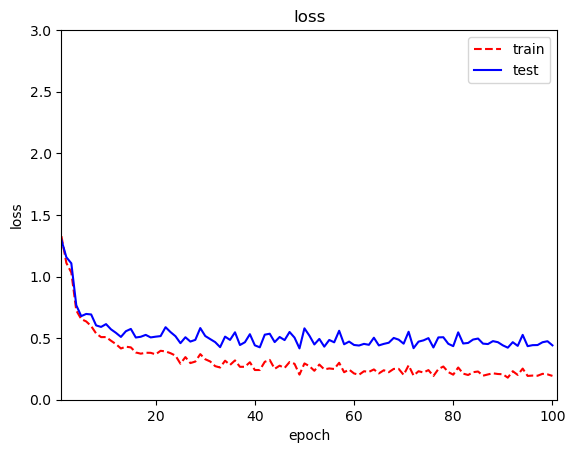

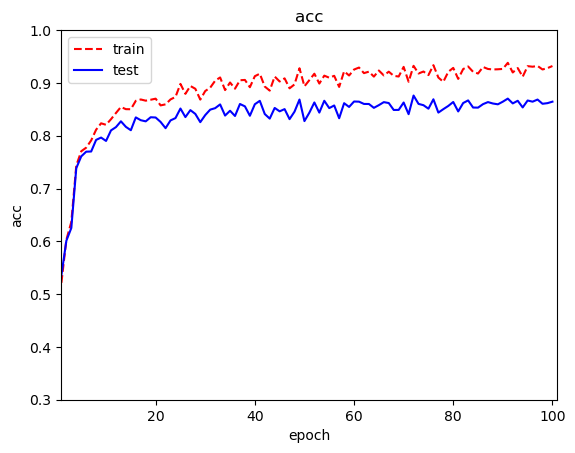

In [15]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = clf
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.axis([1, epochs+1, 0, 3])
x = range(1, epochs+1)
plt.plot(x, torch.tensor(train_loss_list, device='cpu'), color='r', linewidth=1.5, linestyle='--', label='train')
plt.plot(x, torch.tensor(test_loss_list, device='cpu'), 'b', label='test')
plt.legend()  # 右上角显示各个曲线代表什么意思
plt.show()

plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.axis([1, epochs+1, 0.3, 1])
x = range(1, epochs+1)
plt.plot(x, torch.tensor(train_acc_list, device='cpu'), color='r', linewidth=1.5, linestyle='--', label='train')
plt.plot(x, torch.tensor(test_acc_list, device='cpu'), 'b', label='test')
plt.legend()  # 右上角显示各个曲线代表什么意思
plt.show()

## 提交方式
<font color=Red>包含运行结果的Jupyter notebook文件请命名为 `work3_<姓名>_<学号>.ipynb` 提交到乐学平时小作业3中</font>